In [1]:
!pip install xgboost shap scikit-learn pandas numpy matplotlib seaborn -q

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, classification_report
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import shap
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 60)
print("GOLF PERFORMANCE ANALYSIS - PREDICTIVE MODEL")
print("=" * 60)
print("\n All libraries imported successfully\n")


GOLF PERFORMANCE ANALYSIS - PREDICTIVE MODEL

 All libraries imported successfully



In [4]:
# Data loading and preparation
print("=" * 60)
print("STEP 1: DATA LOADING")
print("=" * 60)

# My golf data - 15 tournament round
data = {
    'Round': list(range(1, 16)),
    'Score': [69, 74, 79, 73, 75, 76, 72, 75, 77, 75, 74, 80, 77, 74, 73],
    'FIR%': [78.6, 57.1, 42.9, 64.3, 50.0, 57.1, 64.3, 50.0, 42.9, 57.1, 57.1, 35.7, 50.0, 64.3, 57.1],
    'GIR%': [72.2, 50.0, 38.9, 55.6, 44.4, 38.9, 61.1, 50.0, 38.9, 44.4, 50.0, 33.3, 38.9, 55.6, 50.0],
    'Putts': [28, 32, 33, 31, 32, 33, 30, 32, 34, 32, 31, 35, 33, 30, 31],
    'Up&Down%': [66.7, 40.0, 25.0, 50.0, 33.3, 37.5, 50.0, 28.6, 20.0, 33.3, 40.0, 16.7, 25.0, 44.4, 50.0]
}

df = pd.DataFrame(data)

print("\n Dataset Overview:")
print(df)
print(f"\n✓ Successfully loaded {len(df)} rounds of data")
print(f"✓ Features: FIR%, GIR%, Putts, Up&Down%")
print(f"✓ Target: Score (Range: {df['Score'].min()}-{df['Score'].max()})")


STEP 1: DATA LOADING

 Dataset Overview:
    Round  Score  FIR%  GIR%  Putts  Up&Down%
0       1     69  78.6  72.2     28      66.7
1       2     74  57.1  50.0     32      40.0
2       3     79  42.9  38.9     33      25.0
3       4     73  64.3  55.6     31      50.0
4       5     75  50.0  44.4     32      33.3
5       6     76  57.1  38.9     33      37.5
6       7     72  64.3  61.1     30      50.0
7       8     75  50.0  50.0     32      28.6
8       9     77  42.9  38.9     34      20.0
9      10     75  57.1  44.4     32      33.3
10     11     74  57.1  50.0     31      40.0
11     12     80  35.7  33.3     35      16.7
12     13     77  50.0  38.9     33      25.0
13     14     74  64.3  55.6     30      44.4
14     15     73  57.1  50.0     31      50.0

✓ Successfully loaded 15 rounds of data
✓ Features: FIR%, GIR%, Putts, Up&Down%
✓ Target: Score (Range: 69-80)



STEP 2: EXPLORATORY DATA ANALYSIS

 Summary Statistics:
       Score   FIR%   GIR%  Putts  Up&Down%
count  15.00  15.00  15.00  15.00     15.00
mean   74.87  55.23  48.15  31.80     37.37
std     2.75  10.62  10.22   1.74     13.49
min    69.00  35.70  33.30  28.00     16.70
25%    73.50  50.00  38.90  31.00     26.80
50%    75.00  57.10  50.00  32.00     37.50
75%    76.50  60.70  52.80  33.00     47.20
max    80.00  78.60  72.20  35.00     66.70

 Correlation with Score (negative = better for lower scores):
  GIR%        : -0.942
  Up&Down%    : -0.942
  FIR%        : -0.936
  Putts       : +0.935


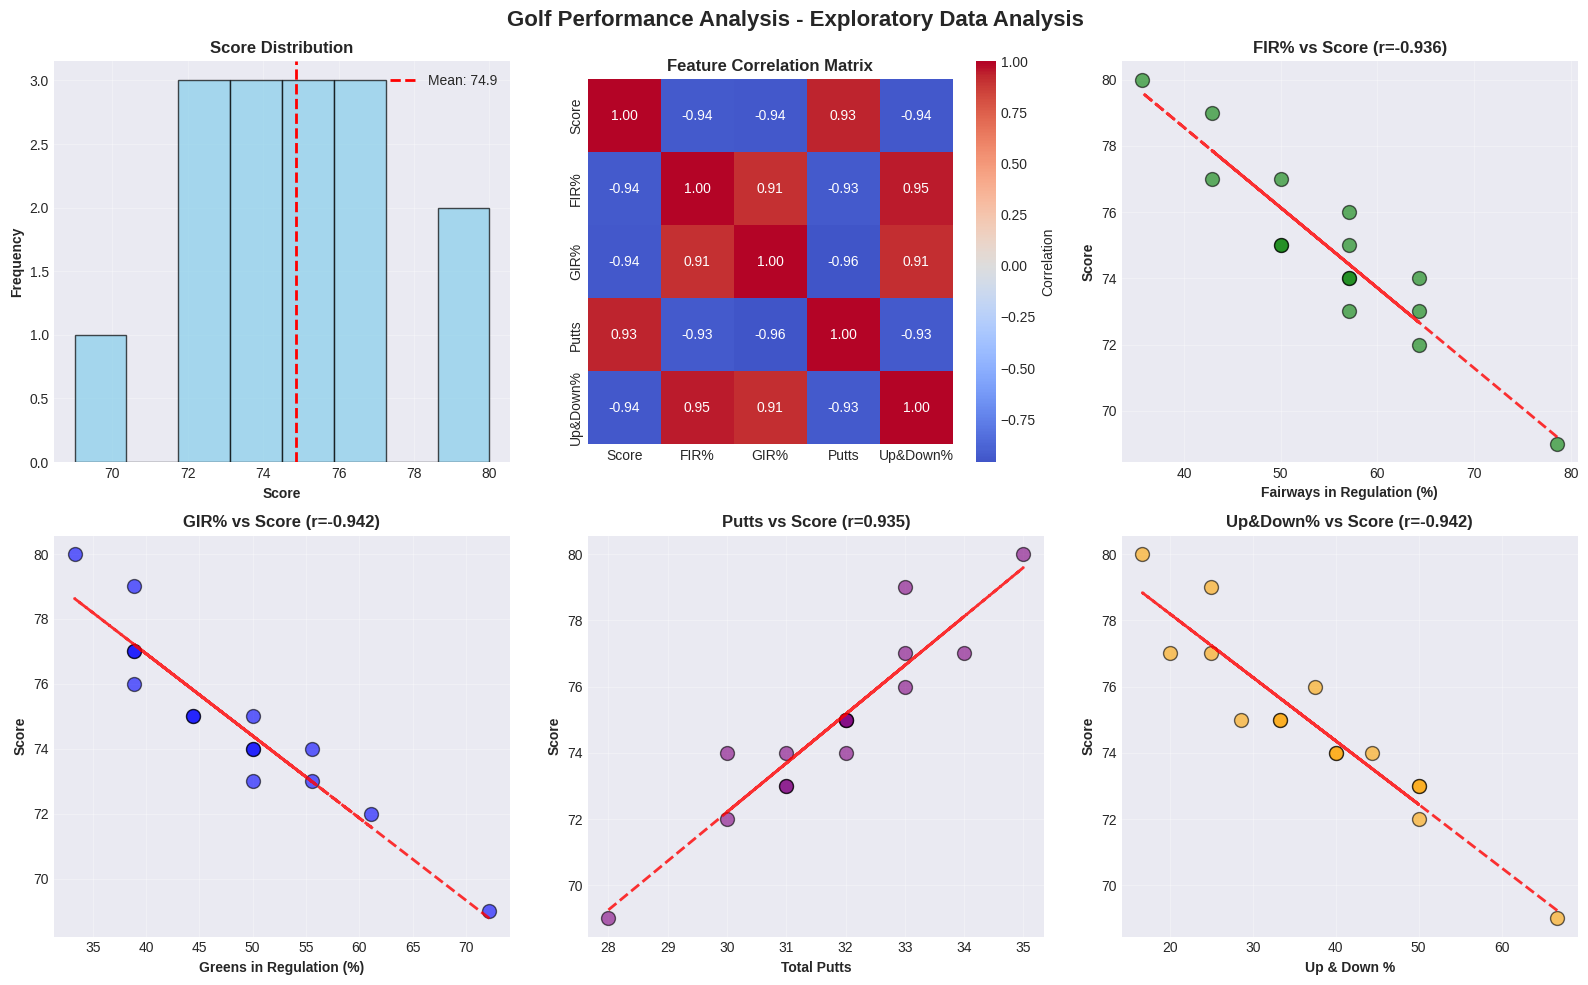

In [5]:
# Data analysis
print("\n" + "=" * 60)
print("STEP 2: EXPLORATORY DATA ANALYSIS")
print("=" * 60)

# Summary statistics
print("\n Summary Statistics:")
print(df[['Score', 'FIR%', 'GIR%', 'Putts', 'Up&Down%']].describe().round(2))

# Calculate correlations
correlations = df[['FIR%', 'GIR%', 'Putts', 'Up&Down%']].corrwith(df['Score']).sort_values()
print("\n Correlation with Score (negative = better for lower scores):")
for stat, corr in correlations.items():
    print(f"  {stat:12s}: {corr:+.3f}")

# Create visualization figure
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Golf Performance Analysis - Exploratory Data Analysis', fontsize=16, fontweight='bold')

# 1. Score distribution
axes[0, 0].hist(df['Score'], bins=8, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df['Score'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["Score"].mean():.1f}')
axes[0, 0].set_xlabel('Score', fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontweight='bold')
axes[0, 0].set_title('Score Distribution', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Correlation heatmap
features_for_corr = df[['Score', 'FIR%', 'GIR%', 'Putts', 'Up&Down%']]
corr_matrix = features_for_corr.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, ax=axes[0, 1], cbar_kws={'label': 'Correlation'}, fmt='.2f')
axes[0, 1].set_title('Feature Correlation Matrix', fontweight='bold')

# 3. FIR% vs Score
axes[0, 2].scatter(df['FIR%'], df['Score'], s=100, alpha=0.6, color='green', edgecolors='black')
z = np.polyfit(df['FIR%'], df['Score'], 1)
p = np.poly1d(z)
axes[0, 2].plot(df['FIR%'], p(df['FIR%']), "r--", alpha=0.8, linewidth=2)
axes[0, 2].set_xlabel('Fairways in Regulation (%)', fontweight='bold')
axes[0, 2].set_ylabel('Score', fontweight='bold')
axes[0, 2].set_title(f'FIR% vs Score (r={correlations["FIR%"]:.3f})', fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)

# 4. GIR% vs Score
axes[1, 0].scatter(df['GIR%'], df['Score'], s=100, alpha=0.6, color='blue', edgecolors='black')
z = np.polyfit(df['GIR%'], df['Score'], 1)
p = np.poly1d(z)
axes[1, 0].plot(df['GIR%'], p(df['GIR%']), "r--", alpha=0.8, linewidth=2)
axes[1, 0].set_xlabel('Greens in Regulation (%)', fontweight='bold')
axes[1, 0].set_ylabel('Score', fontweight='bold')
axes[1, 0].set_title(f'GIR% vs Score (r={correlations["GIR%"]:.3f})', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 5. Putts vs Score
axes[1, 1].scatter(df['Putts'], df['Score'], s=100, alpha=0.6, color='purple', edgecolors='black')
z = np.polyfit(df['Putts'], df['Score'], 1)
p = np.poly1d(z)
axes[1, 1].plot(df['Putts'], p(df['Putts']), "r--", alpha=0.8, linewidth=2)
axes[1, 1].set_xlabel('Total Putts', fontweight='bold')
axes[1, 1].set_ylabel('Score', fontweight='bold')
axes[1, 1].set_title(f'Putts vs Score (r={correlations["Putts"]:.3f})', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# 6. Up&Down% vs Score
axes[1, 2].scatter(df['Up&Down%'], df['Score'], s=100, alpha=0.6, color='orange', edgecolors='black')
z = np.polyfit(df['Up&Down%'], df['Score'], 1)
p = np.poly1d(z)
axes[1, 2].plot(df['Up&Down%'], p(df['Up&Down%']), "r--", alpha=0.8, linewidth=2)
axes[1, 2].set_xlabel('Up & Down %', fontweight='bold')
axes[1, 2].set_ylabel('Score', fontweight='bold')
axes[1, 2].set_title(f'Up&Down% vs Score (r={correlations["Up&Down%"]:.3f})', fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [6]:
# Regression models - predicting exact score
print("\n" + "=" * 60)
print("REGRESSION MODELS - SCORE PREDICTION")
print("=" * 60)

# Prepare features and target
X = df[['FIR%', 'GIR%', 'Putts', 'Up&Down%']].values
y = df['Score'].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
}

# Store results
results = {}

print("\n Model Performance (Leave-One-Out Cross-Validation):\n")

for name, model in models.items():
    # Leave-One-Out CV for small dataset
    loo = LeaveOneOut()
    mae_scores = []
    r2_scores = []

    for train_idx, test_idx in loo.split(X_scaled):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae_scores.append(abs(y_test[0] - y_pred[0]))

    avg_mae = np.mean(mae_scores)
    std_mae = np.std(mae_scores)

    results[name] = {
        'MAE': avg_mae,
        'MAE_std': std_mae,
        'model': model
    }

    print(f"{name:20s}: MAE = {avg_mae:.2f} ± {std_mae:.2f} strokes")

# Train final models on full dataset for feature importance
for name, model in models.items():
    model.fit(X_scaled, y)



REGRESSION MODELS - SCORE PREDICTION

 Model Performance (Leave-One-Out Cross-Validation):

Linear Regression   : MAE = 0.90 ± 0.60 strokes
Random Forest       : MAE = 0.94 ± 1.01 strokes
XGBoost             : MAE = 1.04 ± 1.01 strokes


In [7]:
# Classification models - good vs bad rounds
print("\n" + "=" * 60)
print("CLASSIFICATION MODELS - GOOD VS BAD ROUNDS")
print("=" * 60)

# Create binary target: Good round (< 75) vs Bad round (>= 75)
threshold = 75
df['Performance'] = (df['Score'] < threshold).astype(int)
df['Performance_Label'] = df['Performance'].map({1: 'Good (<75)', 0: 'Bad (≥75)'})

print(f"\n Performance Classification (Threshold: {threshold}):")
print(df['Performance_Label'].value_counts())

y_class = df['Performance'].values

# Classification models
clf_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42, eval_metric='logloss')
}

print("\n Classification Accuracy (Leave-One-Out CV):\n")

clf_results = {}
for name, model in clf_models.items():
    loo = LeaveOneOut()
    predictions = []
    actuals = []

    for train_idx, test_idx in loo.split(X_scaled):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y_class[train_idx], y_class[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        predictions.append(y_pred[0])
        actuals.append(y_test[0])

    accuracy = np.mean(np.array(predictions) == np.array(actuals))
    clf_results[name] = accuracy

    print(f"{name:20s}: Accuracy = {accuracy:.1%}")

# Train on full dataset
for name, model in clf_models.items():
    model.fit(X_scaled, y_class)



CLASSIFICATION MODELS - GOOD VS BAD ROUNDS

 Performance Classification (Threshold: 75):
Performance_Label
Bad (≥75)     8
Good (<75)    7
Name: count, dtype: int64

 Classification Accuracy (Leave-One-Out CV):

Random Forest       : Accuracy = 86.7%
XGBoost             : Accuracy = 86.7%



STEP 5: FEATURE IMPORTANCE ANALYSIS

 Calculating SHAP values for XGBoost model...

 Feature Importance Ranking (%):

 Feature  Random Forest   XGBoost  SHAP (XGBoost)
    GIR%      27.821715 69.745537       45.731216
Up&Down%      39.433884 22.988773       25.934059
    FIR%       8.595872  5.195518       22.699074
   Putts      24.148529  2.070179        5.635652


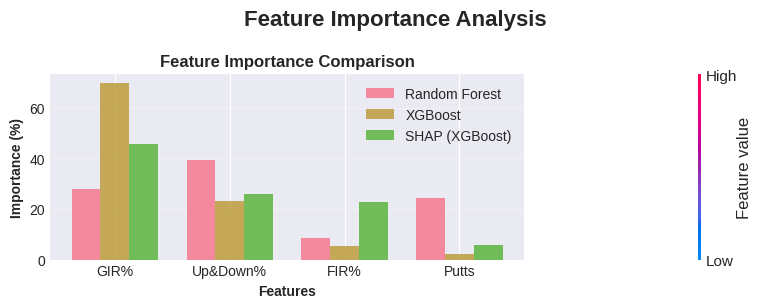

In [8]:
# feature importance analysis
print("\n" + "=" * 60)
print("STEP 5: FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

feature_names = ['FIR%', 'GIR%', 'Putts', 'Up&Down%']

# Random Forest Feature Importance
rf_model = models['Random Forest']
rf_importance = rf_model.feature_importances_

# XGBoost Feature Importance
xgb_model = models['XGBoost']
xgb_importance = xgb_model.feature_importances_

# SHAP Analysis for XGBoost
print("\n Calculating SHAP values for XGBoost model...")
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_scaled)
shap_importance = np.abs(shap_values).mean(axis=0)

# Create importance comparison
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Random Forest': rf_importance,
    'XGBoost': xgb_importance,
    'SHAP (XGBoost)': shap_importance
})

# Normalize for comparison
for col in ['Random Forest', 'XGBoost', 'SHAP (XGBoost)']:
    importance_df[col] = importance_df[col] / importance_df[col].sum() * 100

print("\n Feature Importance Ranking (%):\n")
print(importance_df.sort_values('SHAP (XGBoost)', ascending=False).to_string(index=False))

# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Feature Importance Analysis', fontsize=16, fontweight='bold')

# Bar chart comparison
importance_melted = importance_df.melt(id_vars='Feature', var_name='Method', value_name='Importance')
x_pos = np.arange(len(feature_names))
width = 0.25

for i, method in enumerate(['Random Forest', 'XGBoost', 'SHAP (XGBoost)']):
    values = importance_df.sort_values('SHAP (XGBoost)', ascending=False)[method].values
    axes[0].bar(x_pos + i*width, values, width, label=method, alpha=0.8)

axes[0].set_xlabel('Features', fontweight='bold')
axes[0].set_ylabel('Importance (%)', fontweight='bold')
axes[0].set_title('Feature Importance Comparison', fontweight='bold')
axes[0].set_xticks(x_pos + width)
axes[0].set_xticklabels(importance_df.sort_values('SHAP (XGBoost)', ascending=False)['Feature'])
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# SHAP summary plot
shap.summary_plot(shap_values, X_scaled, feature_names=feature_names, show=False)
plt.title('SHAP Summary Plot - Feature Impact on Score', fontweight='bold')
axes[1].remove()
plt.tight_layout()
plt.show()



In [9]:
# Insights and recommendations
print("\n" + "=" * 60)
print("INSIGHTS & RECOMMENDATIONS")
print("=" * 60)

# Calculate performance thresholds
good_rounds = df[df['Performance'] == 1]
bad_rounds = df[df['Performance'] == 0]

print("\n Performance Analysis:")
print(f"\nGood Rounds (Score < {threshold}):")
for col in ['FIR%', 'GIR%', 'Putts', 'Up&Down%']:
    print(f"  {col:12s}: {good_rounds[col].mean():.1f} (avg)")

print(f"\nBad Rounds (Score ≥ {threshold}):")
for col in ['FIR%', 'GIR%', 'Putts', 'Up&Down%']:
    print(f"  {col:12s}: {bad_rounds[col].mean():.1f} (avg)")

# Top features by SHAP
top_features = importance_df.sort_values('SHAP (XGBoost)', ascending=False)

print("\n" + "=" * 60)
print("KEY FINDINGS & PRACTICE RECOMMENDATIONS")
print("=" * 60)

print(f"\n1. MOST IMPORTANT STATS (Ranked by SHAP importance):")
for idx, row in top_features.iterrows():
    print(f"   {idx+1}. {row['Feature']:12s} - {row['SHAP (XGBoost)']:.1f}% importance")

print(f"\n2. CORRELATION INSIGHTS:")
for stat, corr in correlations.items():
    direction = "LOWER scores" if corr < 0 else "HIGHER scores"
    strength = "Strong" if abs(corr) > 0.5 else "Moderate" if abs(corr) > 0.3 else "Weak"
    print(f"   • {stat:12s}: {strength} correlation with {direction} (r={corr:+.3f})")

print(f"\n3. PERFORMANCE THRESHOLDS (for sub-{threshold} rounds):")
for col in ['FIR%', 'GIR%', 'Putts', 'Up&Down%']:
    good_avg = good_rounds[col].mean()
    bad_avg = bad_rounds[col].mean()
    diff = good_avg - bad_avg
    print(f"   • {col:12s}: Target ≥ {good_avg:.1f}% (vs {bad_avg:.1f}% in bad rounds, Δ={diff:+.1f})")

print("\n" + "=" * 60)
print("🏌️ PRACTICE PRIORITIES FOR SPRING/SIMULATOR")
print("=" * 60)

# Recommend top 3 areas based on SHAP and correlation
priorities = []
for idx, row in top_features.head(3).iterrows():
    feature = row['Feature']
    importance = row['SHAP (XGBoost)']
    corr = correlations[feature]

    if feature == 'GIR%':
        recommendation = "Iron accuracy and approach shots - most predictive of low scores"
    elif feature == 'Putts':
        recommendation = "Putting - focus on lag putting and eliminating 3-putts"
    elif feature == 'FIR%':
        recommendation = "Driving accuracy - consistent ball striking off the tee"
    elif feature == 'Up&Down%':
        recommendation = "Short game - chipping and sand play around the greens"
    else:
        recommendation = "General skill development"

    priorities.append(f"Priority {idx+1}: {feature} ({importance:.1f}% importance)\n   → {recommendation}")

for priority in priorities:
    print(f"\n{priority}")

print("\n" + "=" * 60)
print(" ANALYSIS COMPLETE")
print("=" * 60)
print("\nYour model is ready. Use these insights to focus your practice sessions.")
print("Track future rounds and re-run this analysis to validate improvements.")



INSIGHTS & RECOMMENDATIONS

 Performance Analysis:

Good Rounds (Score < 75):
  FIR%        : 63.3 (avg)
  GIR%        : 56.4 (avg)
  Putts       : 30.4 (avg)
  Up&Down%    : 48.7 (avg)

Bad Rounds (Score ≥ 75):
  FIR%        : 48.2 (avg)
  GIR%        : 41.0 (avg)
  Putts       : 33.0 (avg)
  Up&Down%    : 27.4 (avg)

KEY FINDINGS & PRACTICE RECOMMENDATIONS

1. MOST IMPORTANT STATS (Ranked by SHAP importance):
   2. GIR%         - 45.7% importance
   4. Up&Down%     - 25.9% importance
   1. FIR%         - 22.7% importance
   3. Putts        - 5.6% importance

2. CORRELATION INSIGHTS:
   • GIR%        : Strong correlation with LOWER scores (r=-0.942)
   • Up&Down%    : Strong correlation with LOWER scores (r=-0.942)
   • FIR%        : Strong correlation with LOWER scores (r=-0.936)
   • Putts       : Strong correlation with HIGHER scores (r=+0.935)

3. PERFORMANCE THRESHOLDS (for sub-75 rounds):
   • FIR%        : Target ≥ 63.3% (vs 48.2% in bad rounds, Δ=+15.0)
   • GIR%        : Tar